In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [7]:
x_train.shape

(50000, 32, 32, 3)

### Hyper Parameters

In [9]:
input_shape = (32,32,3)
num_classes = 10
batch_size = 64
num_epochs = 5
img_size = 72
patch_size = 6
num_patches = (img_size//patch_size)**2
learning_rate = 0.001
weight_decay = 0.0001
projection_dimensions = 64
num_heads = 4
transformer_units = [projection_dimensions*2,projection_dimensions]
transformer_layers = 8
mlp_head_unit = [2048,1024]



In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes = [1,self.patch_size,self.patch_size,1],
            strides = [1,self.patch_size,self.patch_size,1],
            rates = [1,1,1,1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches
       


In [13]:
class Patchencoder(layers.Layer):
    def __init__(self, num_patches, projection_dimensions):
        super(Patchencoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dimensions)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dimensions)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

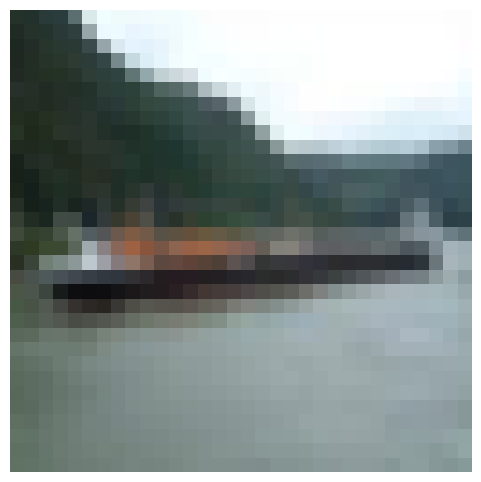

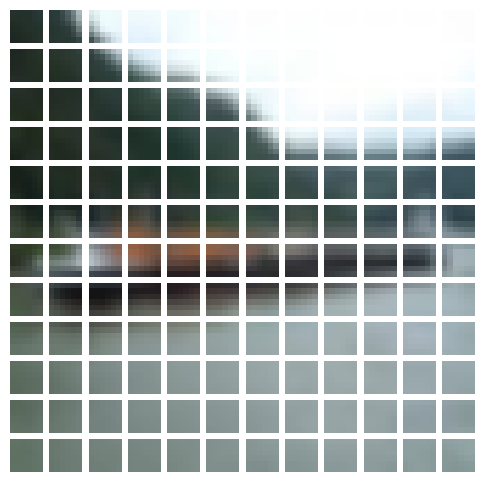

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
image = x_train[np.random.choice(x_train.shape[0])]
plt.imshow(image.astype('uint8'))
plt.axis('off')


resized_img  = tf.image.resize(tf.convert_to_tensor([image]),size=(img_size,img_size))
patches = Patches(patch_size)(resized_img)

n= int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(6,6))
for i,patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch,(patch_size,patch_size,3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')
    

### Data Augmentation

In [17]:
data_aug = tf.keras.Sequential([
    layers.Normalization(),
    layers.Resizing(img_size,img_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor=0.2,width_factor=0.2)
],name='data_aug')
data_aug.layers[0].adapt(x_train)

### MLP Block

In [19]:
def mlp(x,hidden_units,dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units,activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [21]:
def ViT_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_aug(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = Patchencoder(num_patches, projection_dimensions)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        att_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dimensions, dropout=0.1)(x1, x1)
        x2 = layers.Add()([att_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-2)(x2)
        x4 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x4])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_unit, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)

    model = tf.keras.Model(inputs=inputs, outputs=logits)
    
    return model

In [23]:
import tensorflow as tf

def run_program(model):
    # Using TensorFlow's Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Manually adding weight decay to the loss function
    def add_weight_decay_loss(loss):
        weight_decay_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
        return loss + weight_decay * weight_decay_loss

    # Compile the model using a custom loss function
    model.compile(
        optimizer=optimizer,
        loss=lambda y_true, y_pred: add_weight_decay_loss(
            tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        ),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_accuracy"),
        ],
    )

    # Save the best model during training
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    # Fit the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]
    )

    # Load the best weights and evaluate the model
    model.load_weights(checkpoint_filepath)
    accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(accuracy, "\n")
    print(top_5_accuracy)


In [25]:
import tensorflow as tf

def run_program(model):
    # Using TensorFlow's Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Manually adding weight decay to the loss function
    def add_weight_decay_loss(loss):
        weight_decay_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
        return loss + weight_decay * weight_decay_loss

    # Compile the model using a custom loss function
    model.compile(
        optimizer=optimizer,
        loss=lambda y_true, y_pred: add_weight_decay_loss(
            tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        ),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_accuracy"),
        ],
    )

    # Save the best model during training
    checkpoint_filepath = ".weights.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    # Fit the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]
    )

    # Load the best weights and evaluate the model
    model.load_weights(checkpoint_filepath)
    accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(accuracy, "\n")
    print(top_5_accuracy)



In [ ]:
vit_classifier = ViT_classifier()
history = run_program(vit_classifier)
